<h2> Importing Required Libraries</h2>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings ('ignore')
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import EarlyStopping
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
def calc_r2_bar(m, n, r2):    
    dfr = n - 1                     #number of features
    df = m - n                      #number of data points
    rdf = (dfr + df) / df           #ratio of total degrees of freedom to degrees of freedom for error 
    r2_bar = 1 - rdf * (1 - r2)
    return r2_bar

<h3>Loading the Dataset</h3> 

In [2]:
data=pd.read_csv("USA_Housing.csv")

In [3]:
data

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05
...,...,...,...,...,...,...
4995,60567.94414,7.830362,6.137356,3.46,22837.36103,1.060194e+06
4996,78491.27543,6.999135,6.576763,4.02,25616.11549,1.482618e+06
4997,63390.68689,7.250591,4.805081,2.13,33266.14549,1.030730e+06
4998,68001.33124,5.534388,7.130144,5.44,42625.62016,1.198657e+06


In [4]:
data.shape

(5000, 6)

<h3>Checking the presence of Null values</h3>

In [5]:
data.isnull().sum()

Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
dtype: int64

<p> Now, there are no null values present in the dataset</p>

<h3>Exploratory Data Analysis(EDA)</h3>

In [6]:
data.describe()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,68583.108984,5.977222,6.987792,3.981330,36163.516039,1.232073e+06
std,10657.991214,0.991456,1.005833,1.234137,9925.650114,3.531176e+05
min,17796.631190,2.644304,3.236194,2.000000,172.610686,1.593866e+04
25%,61480.562390,5.322283,6.299250,3.140000,29403.928700,9.975771e+05
50%,68804.286405,5.970429,7.002902,4.050000,36199.406690,1.232669e+06
75%,75783.338665,6.650808,7.665871,4.490000,42861.290770,1.471210e+06
max,107701.748400,9.519088,10.759588,6.500000,69621.713380,2.469066e+06


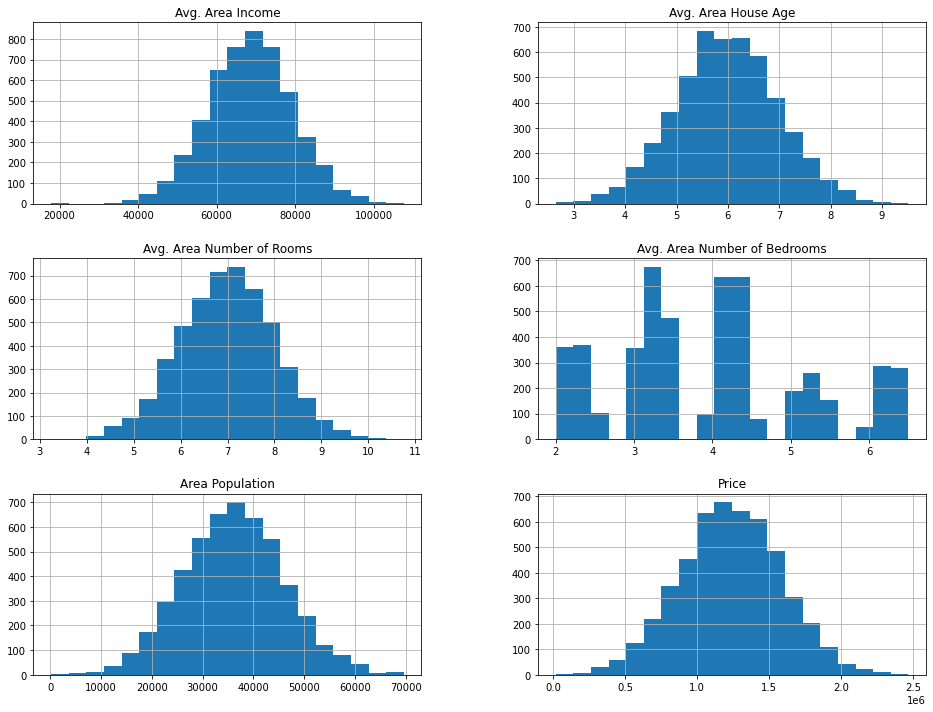

In [7]:
#Plotting Histograms
data.hist(figsize=(16,12),bins=20)
plt.show()

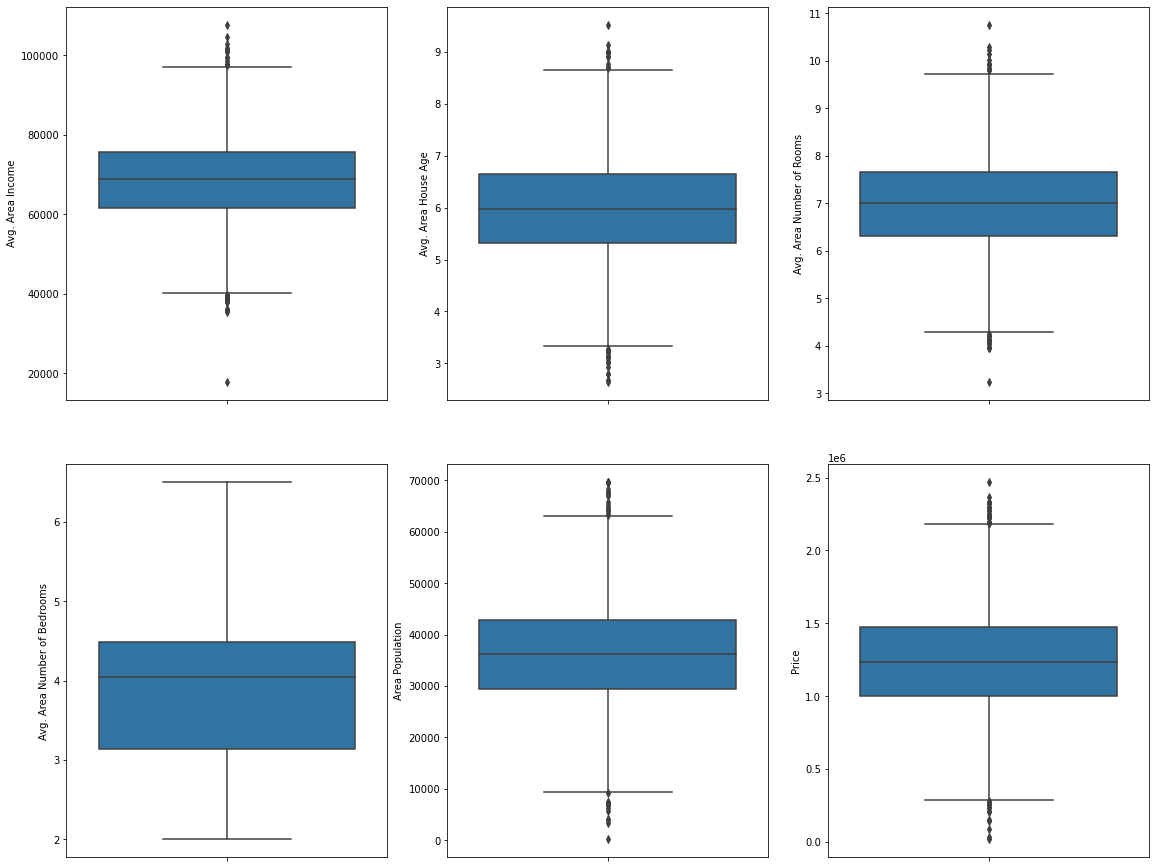

In [8]:
#Boxplots
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16,12))
index = 0
ax = ax.flatten()

for col, value in data.items():
    if col != 'type':
        sns.boxplot(y=col, data=data, ax=ax[index])
        index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

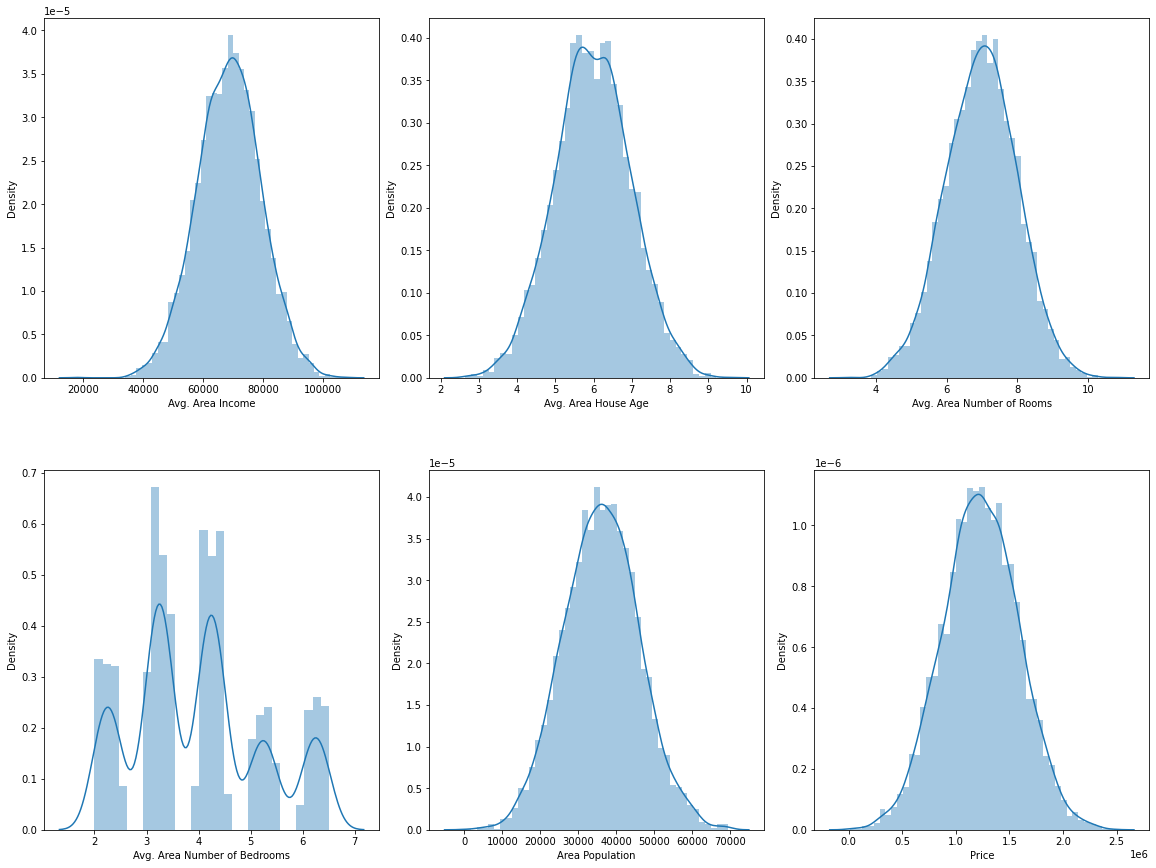

In [9]:
#distribution plot
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16,12))
index = 0
ax = ax.flatten()

for col, value in data.items():
    if col != 'type':
        sns.distplot(value, ax=ax[index])
        index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

<AxesSubplot:>

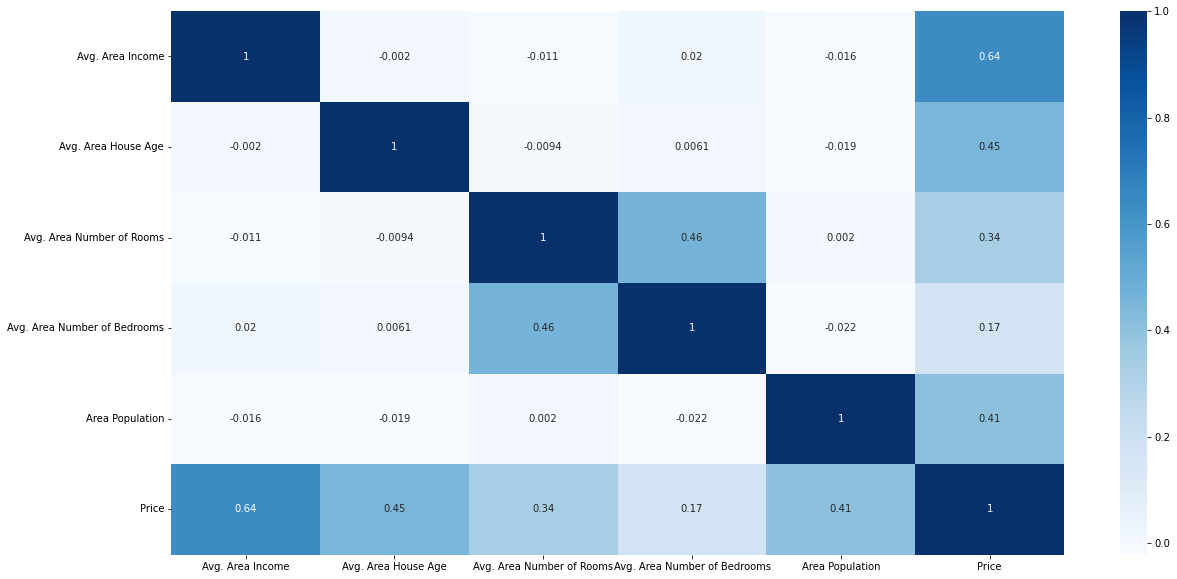

In [10]:
#Correlation Matrix
corr = data.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, cmap='Blues')

<h3>Forward Feature Selection</h3>

In [11]:
x=data.drop('Price',axis=1)
y=data['Price']
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, shuffle=True, random_state=1)
scaler = StandardScaler()
scaler.fit(x)
X_train = pd.DataFrame(scaler.transform(X_train), columns=x.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=x.columns)
y_train=pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [12]:
def adjusted_r2_score(r2, n, k):
    return 1-((1-r2)*(n-1)/(n-k-1))

def regression_fs():
    # create model
    model = Sequential()
    model.add(Dense(i+1, input_dim=i, kernel_initializer='normal', activation='relu'))
    model.add(Dense(i+1, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

columns = X_train.columns.to_list()
fws_col=[]
temp_r2=-1000;

for i in range(1,len(columns)+1):
    H_NN = regression_fs()
    H_NN2 = H_NN.fit(X_train.iloc[:,0:i], y_train, batch_size=10,validation_split = 0.2, verbose=0,epochs=100)
    
    predict_y = H_NN.predict(X_test.iloc[:,0:i])
    r2_fws=r2_score(y_test,predict_y)
    if(r2_fws>temp_r2):
        fws_col.append(columns[i-1])
        temp_r2=r2_fws;

In [13]:
fws_col

['Avg. Area Income',
 'Avg. Area House Age',
 'Avg. Area Number of Rooms',
 'Area Population']

In [14]:
X_train = X_train[fws_col]
X_test = X_test[fws_col]

Building Neural nets with relu activation function


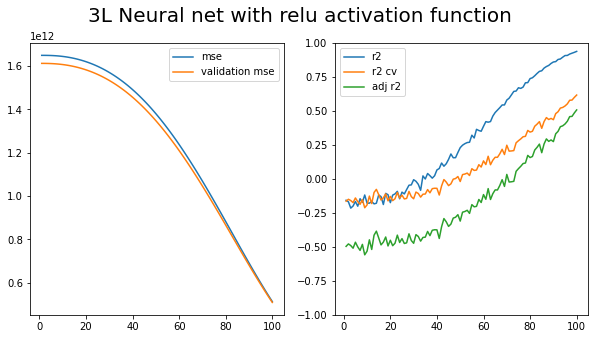

*******************************************************

Building Neural nets with sigmoid activation function


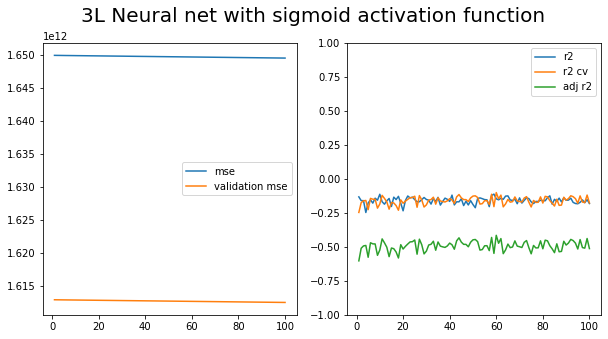

*******************************************************

Building Neural nets with tanh activation function


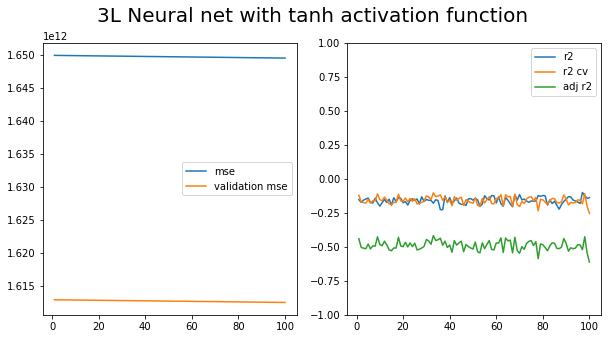

*******************************************************

Building Neural nets with elu activation function


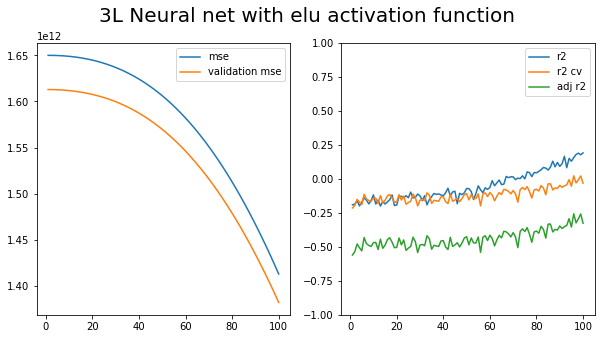

*******************************************************

Building Neural nets with softmax activation function


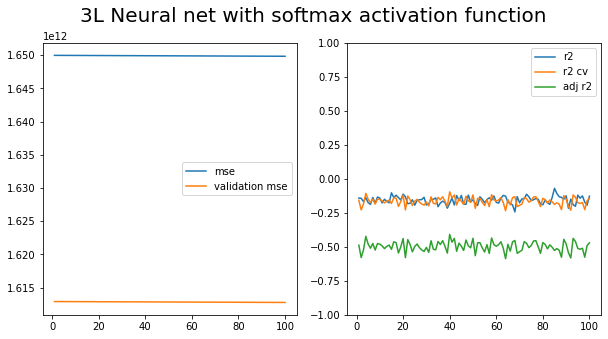

*******************************************************

Building Neural nets with softplus activation function


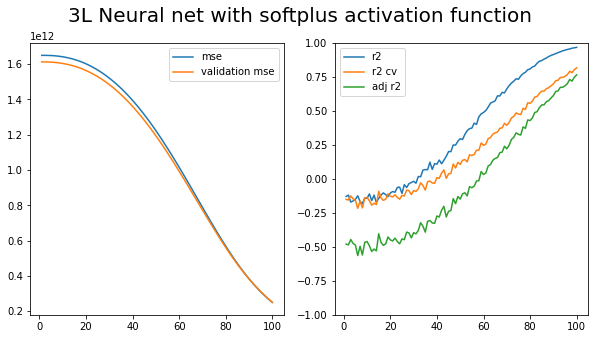

*******************************************************

Building Neural nets with softsign activation function


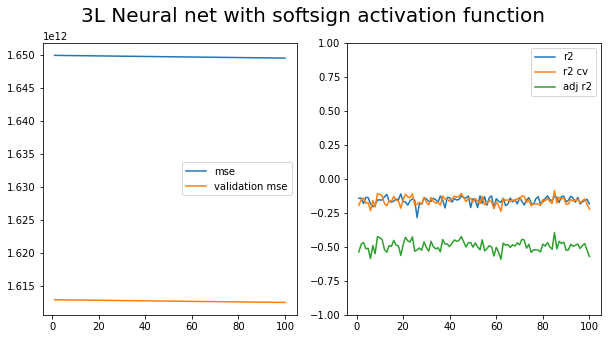

*******************************************************

Building Neural nets with selu activation function


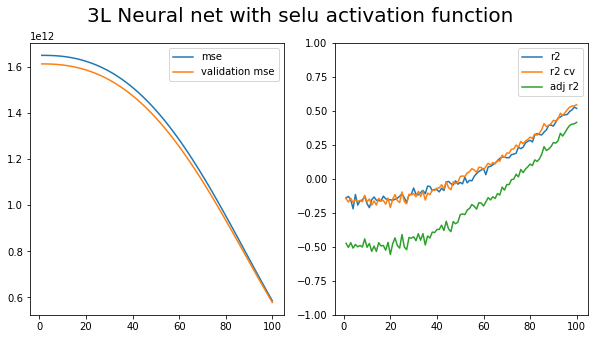

*******************************************************









In [15]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

def adjusted_r2_score(r2, n, k):
    return 1-((1-r2)*(n-1)/(n-k-1))

activation_list = ['relu', 'sigmoid', 'tanh', 'elu','softmax','softplus','softsign','selu']
epoch_arr = [k for k in range(1,101)]

from keras import backend as K

def r2_coeff(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))
    

def adj_r2(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
    return (1 - (1 - r2_coeff(y_true, y_pred)) * (tf.cast(tf.size(y_true), tf.float32) - 1) / (tf.cast(tf.size(y_true), tf.float32) - tf.cast(tf.rank(y_true), tf.float32) - 1))

def regression(i):
    # create model
    model = Sequential()
    model.add(Dense(len(fws_col)+1, input_dim=len(fws_col), kernel_initializer='normal', activation=i))
    model.add(Dense(len(fws_col)+1,activation=i))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse',r2_coeff, adj_r2])
    return model

r2_scores = []
adjusted_r2_scores = []
r2_scores_cv=[]
for i in activation_list:
    print("Building Neural nets with "+i+" activation function")
    Housing_NN = regression(i)
    Housing_NN_cv = regression(i)
    Housing_NN2 = Housing_NN.fit(X_train, y_train, batch_size=10,verbose=0,epochs=100)
    Housing_NN_CV = Housing_NN_cv.fit(X_train, y_train, batch_size=10,validation_split = 0.2, verbose=0,epochs=100)
    plt.subplots(1,2,figsize=(10,5))
    plt.suptitle("3L Neural net with "+i+" activation function", fontsize=20)
    plt.subplot(121)
    plt.plot( epoch_arr, Housing_NN_CV.history['mse'],label="mse")
    plt.plot( epoch_arr,  Housing_NN_CV.history['val_mse'],label="validation mse")
    plt.legend()
    plt.subplot(122)
    plt.plot( epoch_arr, Housing_NN2.history['r2_coeff'],label="r2")
    plt.plot( epoch_arr, Housing_NN_CV.history['r2_coeff'],label="r2 cv")
    plt.plot( epoch_arr, Housing_NN_CV.history['adj_r2'],label="adj r2")
    plt.ylim([-1, 1])
    plt.legend()
    plt.show()
    
    predict_y = Housing_NN.predict(X_test)
    predict_y_cv = Housing_NN_cv.predict(X_test)
    r2=r2_score(y_test,predict_y)
    r2_scores.append(r2)
    adjusted_r2_scores.append(adjusted_r2_score(r2, X_train.shape[0],X_train.shape[1]-1))
    r2_scores_cv.append(r2_score(y_test,predict_y_cv))

    print("*******************************************************\n")
print('\n')
print('\n')
print('\n')

In [18]:
for i in range(len(activation_list)):
    print("R2 for NN using",activation_list[i],"activation is ",r2_scores[i])
    print("Adj R2 for NN using",activation_list[i],"activation is ",adjusted_r2_scores[i])
    print("R2 CV for NN using",activation_list[i],"activation is ",r2_scores_cv[i])
    print('\n')

R2 for NN using relu activation is  0.23792708515915129
Adj R2 for NN using relu activation is  0.2372731324290247
R2 CV for NN using relu activation is  -2.943086505987441


R2 for NN using sigmoid activation is  -11.948177083999271
Adj R2 for NN using sigmoid activation is  -11.95928821994092
R2 CV for NN using sigmoid activation is  -11.94898569079405


R2 for NN using tanh activation is  -11.948158195186
Adj R2 for NN using tanh activation is  -11.95926931491871
R2 CV for NN using tanh activation is  -11.948975321645678


R2 for NN using elu activation is  -7.646489613087944
Adj R2 for NN using elu activation is  -7.653909369620914
R2 CV for NN using elu activation is  -10.059404203199513


R2 for NN using softmax activation is  -11.950895161981018
Adj R2 for NN using softmax activation is  -11.962008630369445
R2 CV for NN using softmax activation is  -11.951163610960782


R2 for NN using softplus activation is  0.5895122937372459
Adj R2 for NN using softplus activation is  0.58916